In [1]:
#classification problem with cats and dogs as a binary output
#we will be using a pre-made keras model, Xception
#pre processing technique from keras

In [2]:
import tensorflow as tf #standard syntax for uploading keras and tensorflow libraries
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip 
#this allows us to upload/download data (curl)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   244M      0  0:00:03  0:00:03 --:--:--  244M


In [4]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls
#unzip and print the file names

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [5]:
!ls PetImages

Cat  Dog


In [6]:
import os #go over current directory where images are saved

num_skipped = 0 
#count how many images there are. We will start from 1. We are opening our images, then checking to see if it has 'JFIF'.
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path): 
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb") #0 -255. This allows us to represent the image in bytes
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close() #closing/cleaning part

        if not is_jfif:
            num_skipped += 1 #increasing by 1
            # Delete corrupted image
            os.remove(fpath) #if there is a corrupted image, then remove it

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [7]:
image_size = (180, 180) #defining image size and batch size. Image size is the pixel resolution that we use as input
batch_size = 32 #For computation we will consider a batch of 32 images while training

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


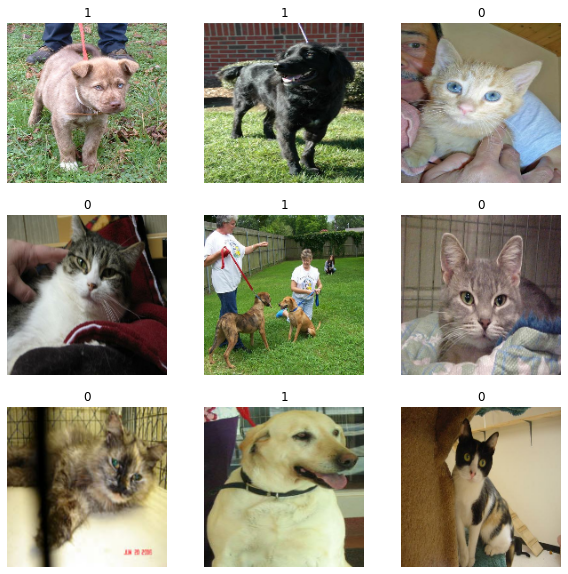

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10)) #establish plot size
for images, labels in train_ds.take(1): #take considering the next image. It will return another image from the directory, folder
    for i in range(9): #this will only show us 9 random images and classify them
        ax = plt.subplot(3, 3, i + 1) #this is a way to arrange our plot positions
        plt.imshow(images[i].numpy().astype("uint8")) #Pixels are uint8 [0-255] uint8 will show us the image in 8 bit integer values
        plt.title(int(labels[i])) #show the labels between [0-1] as this is a binary problem
        plt.axis("off")

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

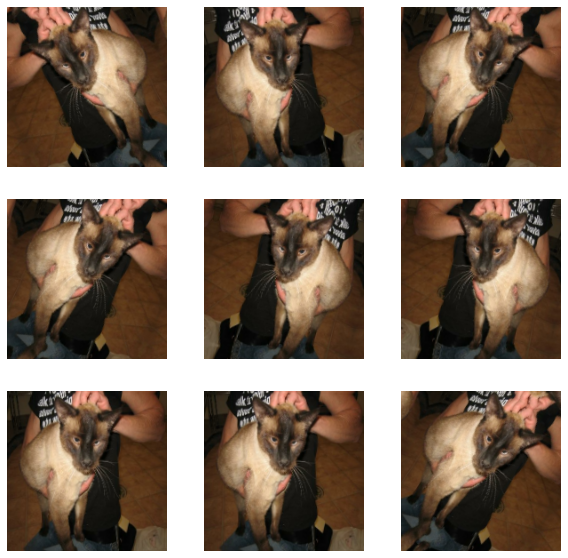

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [11]:
"""pretrained is already trained over millions of images. It is trained with 1000 classes. We can use the model in two ways: 
(1) We can use the architecture as it is, 
(2) we can use the whole architecture + weight, 
(3) we can use their weight, we can fine tune their architecture"""

'pretrained is already trained over millions of images. It is trained with 1000 classes. We can use the model in two ways: \n(1) We can use the architecture as it is, \n(2) we can use the whole architecture + weight, \n(3) we can use their weight, we can fine tune their architecture'

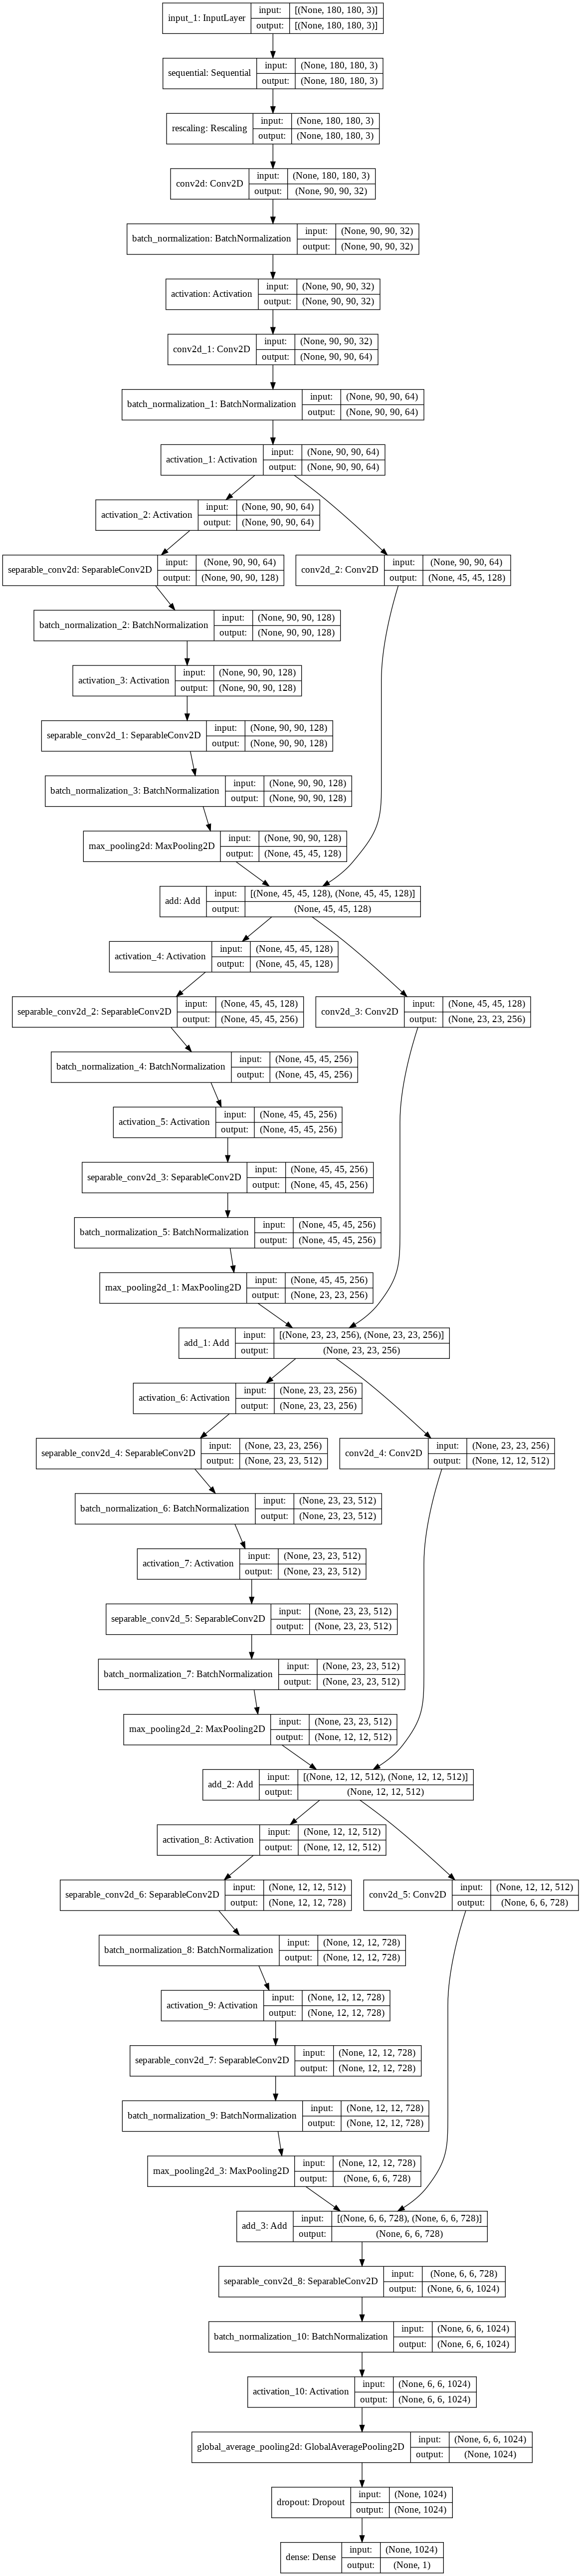

In [12]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs) #Xception takes the input and passes them through the convolutional NN line by line.
    #The input of next layer is the output of the previous layer.

    # Entry block. This is where our convolutional model begins
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x) 
    #we are rescaling the images to normalize the pixel values between [0-1]. This will help compute easier
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x) #32 is the number of filters in the first late
    #3 equals the size of filter, kernal, or feature extractor. this is a 3x3 matrix
    #strides = 2 means that it is moving 2 pixesl at a time
    #padding = same implies that the new matrix will not 
    x = layers.BatchNormalization()(x) #this normalizes the outputs of this layer. Allows for the computation to fast and smoother.
    #Best used before activation
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]: #this makes the model more efficient. You use the outputs as inputs and this saves memory
    #check out the inception model
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [14]:
epochs = 10
#Try different epochs (10,20,...50). The epochs, the more accurate the model becomes. Be mindful that each epoch takes ~ 3 minutes to complete
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
586/586 [==============================] - 172s 290ms/step - loss: 0.6183 - accuracy: 0.6614 - val_loss: 0.5236 - val_accuracy: 0.7488


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
586/586 [==============================] - 169s 288ms/step - loss: 0.4986 - accuracy: 0.7559 - val_loss: 0.4381 - val_accuracy: 0.7920
Epoch 3/10
586/586 [==============================] - 170s 290ms/step - loss: 0.3876 - accuracy: 0.8261 - val_loss: 0.3599 - val_accuracy: 0.8426
Epoch 4/10
586/586 [==============================] - 170s 290ms/step - loss: 0.3219 - accuracy: 0.8593 - val_loss: 0.2687 - val_accuracy: 0.8866
Epoch 5/10
586/586 [==============================] - 170s 290ms/step - loss: 0.2662 - accuracy: 0.8863 - val_loss: 0.2432 - val_accuracy: 0.8915
Epoch 6/10
586/586 [==============================] - 170s 290ms/step - loss: 0.2244 - accuracy: 0.9040 - val_loss: 0.1857 - val_accuracy: 0.9233
Epoch 7/10
586/586 [==============================] - 169s 289ms/step - loss: 0.2040 - accuracy: 0.9146 - val_loss: 0.4358 - val_accuracy: 0.8261
Epoch 8/10
586/586 [==============================] - 170s 290ms/step - loss: 0.1826 - accuracy: 0.9245 - val_loss: 0.1626 -